In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cu126


In [2]:
!pip install torch==2.8.0+cu126 torchaudio==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
!pip install librosa resampy matplotlib pandas


Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.2 MB/s eta 0:00:00


In [3]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00


In [4]:
!pip install torch==2.8.0+cu126 torchaudio==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
!pip install librosa resampy matplotlib pandas


Looking in indexes: https://download.pytorch.org/whl/cu126


In [5]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

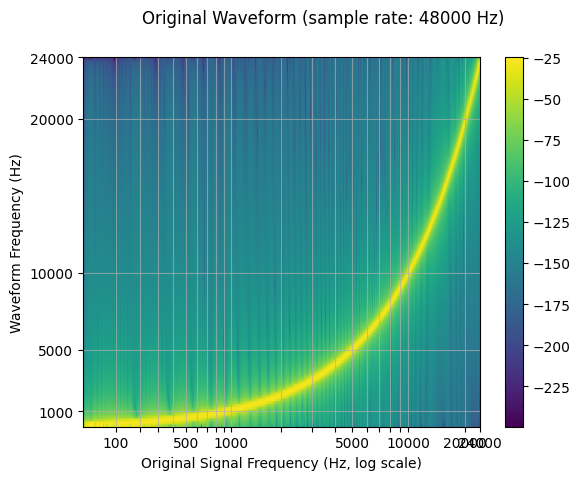

In [6]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

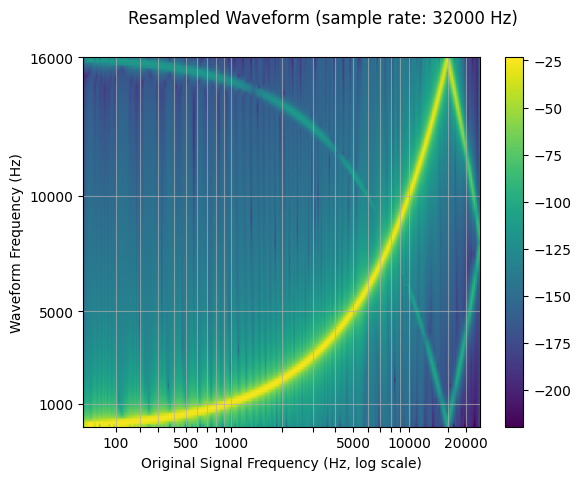

In [7]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

In [14]:
waveform, sample_rate = torchaudio.load("095522039.m4a")
print(waveform.shape, sample_rate)

torch.Size([1, 177152]) 44100


In [24]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

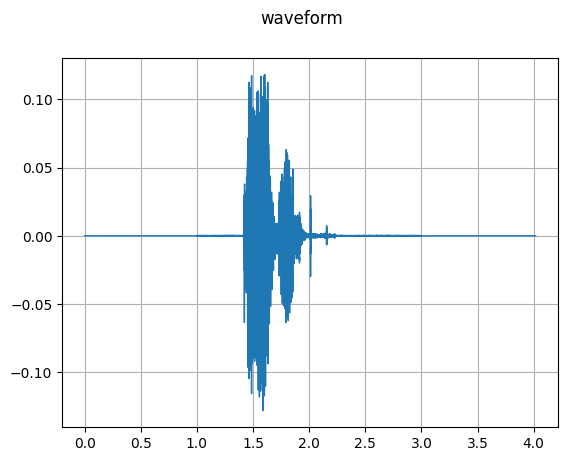

In [25]:
plot_waveform(waveform, sample_rate)

In [26]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


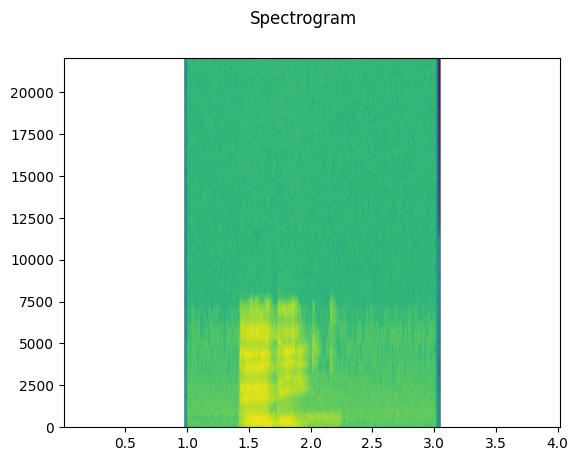

In [27]:
plot_specgram(waveform, sample_rate)

In [28]:
from torchaudio.transforms import Resample
downsampler = Resample(orig_freq=sample_rate, new_freq=16000)
downsampled_waveform = downsampler(waveform)
print(downsampled_waveform.shape)


torch.Size([1, 64273])


In [29]:
upsampler = Resample(orig_freq=16000, new_freq=48000)
upsampled_waveform = upsampler(downsampled_waveform)
print(upsampled_waveform.shape)


torch.Size([1, 192819])


Processing 095522039.m4a ...


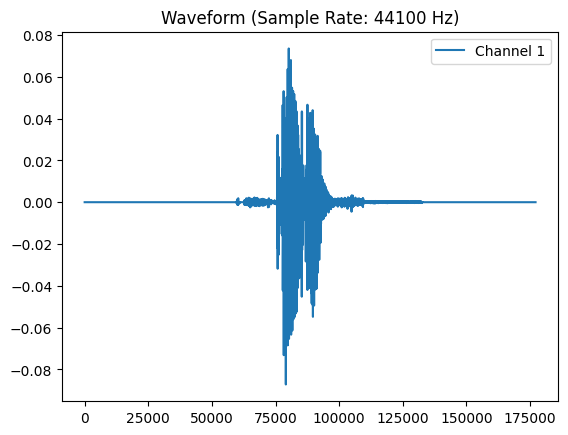

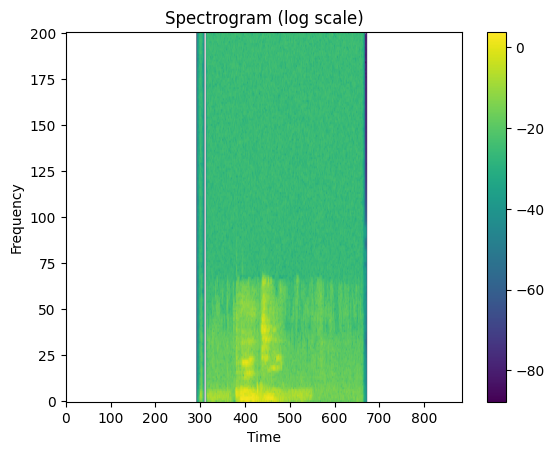

Downsampled from 44100Hz to 16000Hz, shape: torch.Size([1, 64273])
Upsampled from 16000Hz to 48000Hz, shape: torch.Size([1, 192819])
Processing 095522040.m4a ...


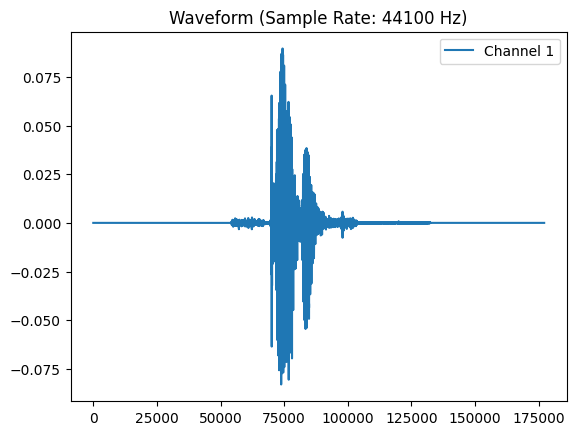

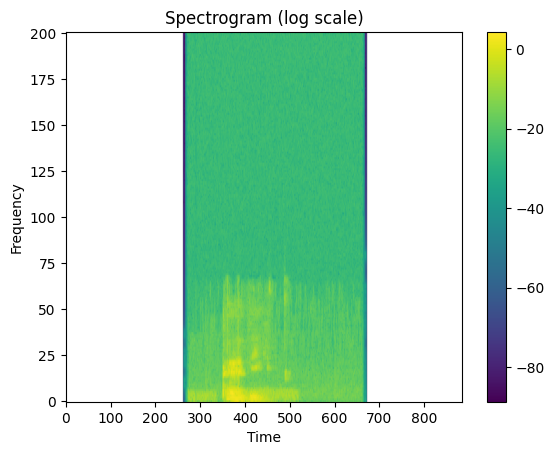

Downsampled from 44100Hz to 16000Hz, shape: torch.Size([1, 64273])
Upsampled from 16000Hz to 48000Hz, shape: torch.Size([1, 192819])
Processing 095522041.m4a ...


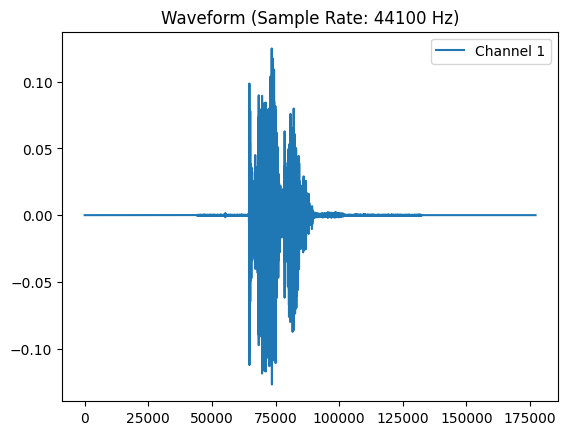

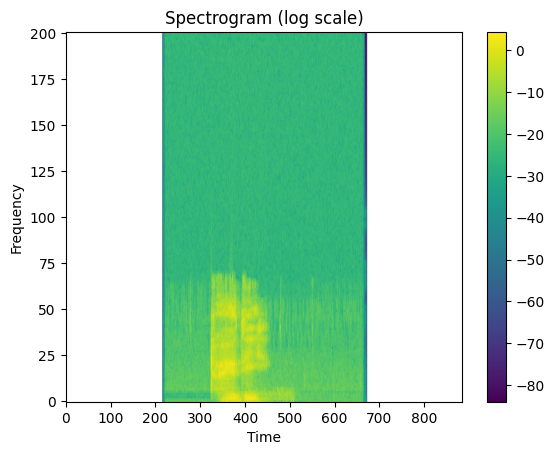

Downsampled from 44100Hz to 16000Hz, shape: torch.Size([1, 64273])
Upsampled from 16000Hz to 48000Hz, shape: torch.Size([1, 192819])
Processing 095522042.m4a ...


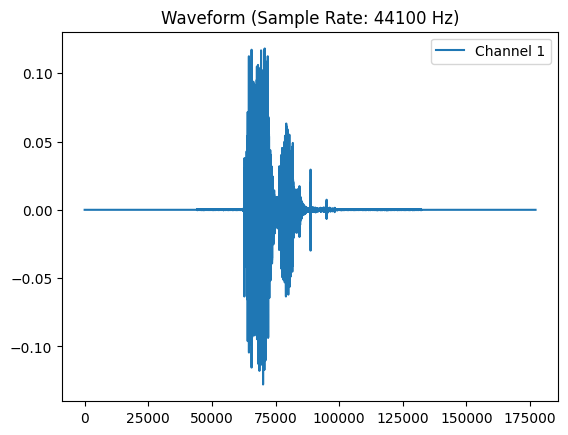

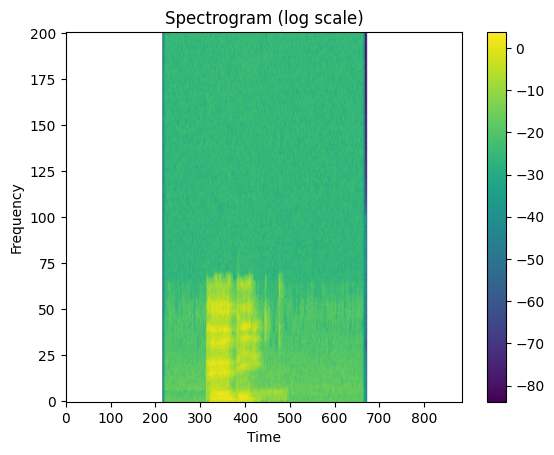

Downsampled from 44100Hz to 16000Hz, shape: torch.Size([1, 64273])
Upsampled from 16000Hz to 48000Hz, shape: torch.Size([1, 192819])


In [31]:
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.transforms import Spectrogram, Resample

# mp4 파일 리스트 (실제 파일명으로 수정)
file_list = ["095522039.m4a", "095522040.m4a", "095522041.m4a", "095522042.m4a"]

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    plt.figure()
    for i in range(waveform.shape[0]):
        plt.plot(waveform[i], label=f"Channel {i+1}")
    plt.title(f"Waveform (Sample Rate: {sample_rate} Hz)")
    plt.legend()
    plt.show()

def plot_spectrogram(waveform, sample_rate):
    spec_transform = Spectrogram()
    spectrogram = spec_transform(waveform)
    plt.figure()
    plt.imshow(spectrogram.log2().numpy()[0], aspect='auto', origin='lower')
    plt.title("Spectrogram (log scale)")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    plt.show()

for filename in file_list:
    print(f"Processing {filename} ...")
    # 1) Load waveform & sample rate from mp4 (audio stream)
    waveform, sample_rate = torchaudio.load(filename)

    # 2) Plot waveform
    plot_waveform(waveform, sample_rate)

    # 3) Plot spectrogram
    plot_spectrogram(waveform, sample_rate)

    # 4) Downsample - 예: 원본에서 16000 Hz로 변환
    target_downsample_rate = 16000
    downsampler = Resample(orig_freq=sample_rate, new_freq=target_downsample_rate)
    downsampled_waveform = downsampler(waveform)
    print(f"Downsampled from {sample_rate}Hz to {target_downsample_rate}Hz, shape: {downsampled_waveform.shape}")

    # 5) Upsample - 예: 16000 Hz → 48000 Hz
    target_upsample_rate = 48000
    upsampler = Resample(orig_freq=target_downsample_rate, new_freq=target_upsample_rate)
    upsampled_waveform = upsampler(downsampled_waveform)
    print(f"Upsampled from {target_downsample_rate}Hz to {target_upsample_rate}Hz, shape: {upsampled_waveform.shape}")
